### TODO

*Create a preprocess script that correctly assigns lat and lon cooridnate dimensions, loops through all files, takes monthly mean, and dumps them into my scratch directory. Then check out some of Wills code for making plots at specific points and seasonally decompose precipitation trends.*

In [5]:
import os
import xarray as xr
import dask
import pymannkendall as mk # consider using.... not this
from dask.diagnostics import ProgressBar
from functools import partial

## Pathing ### ----------------
# nldas_dir = "/glade/campaign/cgd/tss/people/swensosc/NLDAS/"
cesm_forcing_dir = "/glade/campaign/cesm/cesmdata/inputdata/"
nldas_dir = os.path.join(cesm_forcing_dir,
                         "atm/datm7/atm_forcing.datm7.NLDAS2.0.125d.v1")
print(f'NLDAS ATM forcing data dir contents:\n {os.listdir(nldas_dir)}')

ppt_dir = os.path.join(nldas_dir, "Precip")
ppt_fns = [os.path.join(ppt_dir, fn) for fn in os.listdir(ppt_dir)]


NLDAS ATM forcing data dir contents:
 ['Solar', 'ctsmforc.NLDAS2.cdf5.0.125d.v1.ESMFmesh_120620_c210330.nc', 'Precip', 'README_190425', 'TPQWL']


In [6]:
# Function to preprocess each dataset by selecting a region and variable
def _preprocess(ds, lon_bnds, lat_bnds):
    ds = ds.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds))
    return ds[['PRECTmms']]  # Only keep the 'PRECTmms' variable

lon_bnds, lat_bnds = (100, 250), (75, 150)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

In [7]:
# Open the dataset
ds = xr.open_dataset(ppt_fns[0])

# Assign coordinates properly (make sure that the sizes match the original 'lon' and 'lat' dimensions)
ds = ds.assign_coords(longitude=('lon', (360 - ds['LONGXY'].data[0, :]) * -1),
                      latitude=('lat', ds['LATIXY'].data[:, 0]))

# Since 'lon' and 'lat' are not coordinate dimensions, we swap dimensions:
ds = ds.rename({'lon': 'x', 'lat': 'y'})  # rename them to avoid confusion
ds = ds.swap_dims({'x': 'longitude', 'y': 'latitude'})

# Now the dataset should be properly aligned with longitude and latitude as coordinates
print(ds)
ds['PRECTmms'].isel(time=0).plot()


# ds['PRECTmms'].isel(time=0).plot()

TypeError: NetCDF4BackendEntrypoint.open_dataset() got an unexpected keyword argument 'process'

In [ ]:
# Function to preprocess each dataset by selecting a region and variable
def _preprocess(ds, lon_bnds, lat_bnds):
    ds = ds.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds))
    return ds[['PRECTmms']]  # Only keep the 'PRECTmms' variable

lon_bnds, lat_bnds = (100, 250), (75, 150)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

<xarray.Dataset>
Dimensions:    (time: 744, lat: 224, lon: 464, scalar: 1)
Coordinates:
  * time       (time) object 1997-01-01 00:30:00.000054 ... 1997-01-31 23:29:...
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 ... 216 217 218 219 220 221 222 223
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 456 457 458 459 460 461 462 463
    longitude  (lat, lon) float32 124.9 124.8 124.7 124.6 ... 67.31 67.19 67.06
    latitude   (lat, lon) float32 25.06 25.06 25.06 25.06 ... 52.94 52.94 52.94
Dimensions without coordinates: scalar
Data variables:
    LONGXY     (lat, lon) float32 235.1 235.2 235.3 235.4 ... 292.7 292.8 292.9
    LATIXY     (lat, lon) float32 25.06 25.06 25.06 25.06 ... 52.94 52.94 52.94
    EDGEE      (scalar) float32 ...
    EDGEW      (scalar) float32 ...
    EDGES      (scalar) float32 ...
    EDGEN      (scalar) float32 ...
    PRECTmms   (time, lat, lon) float32 ...
Attributes:
    case_title:  NLDAS 1-Hourly Atmospheric Forcing: Precipitation


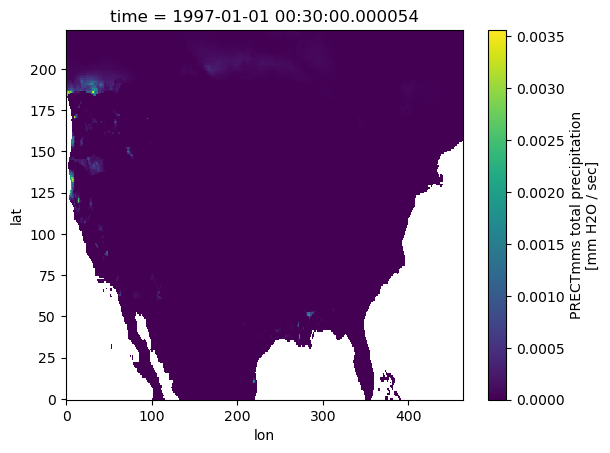

In [27]:

ds = xr.open_dataset(ppt_fns[0])

# Correcting the coordinate transformation and assignment
ds['longitude'] = xr.DataArray(360 - ds['LONGXY'].data, dims=['lat', 'lon'], coords={'lat': ds['lat'], 'lon': ds['lon']})
ds['latitude'] = xr.DataArray(ds['LATIXY'].data, dims=['lat', 'lon'], coords={'lat': ds['lat'], 'lon': ds['lon']})

# Set these as coordinates of the dataset
ds = ds.set_coords(['longitude', 'latitude'])

# Now, to swap dimensions in 'PRECTmms', ensure it uses the correct original dimensions
# This step requires your 'PRECTmms' to actually have 'lon' and 'lat' dimensions
# Check your data structure with print(ds['PRECTmms'])
ds['PRECTmms'] = ds['PRECTmms'].swap_dims({'lon': 'longitude', 'lat': 'latitude'})

# Validate the changes
print(ds)

# Try plotting the first time slice of 'PRECTmms'
ds['PRECTmms'].isel(time=0).plot()

# # Assuming ds is your Dataset and PRECTmms is a variable in the Dataset
# # Adjust the longitude values
# ds['longitude'] = 360 - ds['LONGXY']
# ds['longitude'].values[0:,]
# # # Assign the new longitude values as coordinates, replacing the original 'lon' dimension
# ds['longitude'] = xr.DataArray(360 - ds['LONGXY'].data, dims=['lat', 'lon'], coords={'lat': ds['lat'], 'lon': ds['lon']})


# # Adjust the latitude values
# ds['latitude'] = ds['LATIXY']
# # Assign the new latitude values as coordinates, replacing the original 'lat' dimension
# ds = ds.assign_coords(latitude=('lat', ds['latitude']))

# # Now swap the dimensions in PRECTmms from 'lon' and 'lat' to 'longitude' and 'latitude'
# ds['PRECTmms'] = ds['PRECTmms'].swap_dims({'lon': 'longitude', 'lat': 'latitude'})



# ds['longitude'] = 360 - ds['LONGXY']
# ds['latitude'] = ds['LATIXY']

# ds = ds.set_coords(['longitude', 'latitude'])
# ds = ds.assign_coords(longitude=('lon', ds['longitude']))
# ds = ds.assign_coords(latitude=('lat', ds['latitude']))

# # Replace the existing dimensions with the new geographic coordinates
# ds['PRECTmms'] = ds['PRECTmms'].swap_dims({'x': 'longitude', 'y': 'latitude'})
# print(ds)

# ds['PRECTmms'].isel(time=0).plot()
# Reassign coords method in xr

In [2]:
# Open all files and preprocess nldas data to optimize memory
from functools import partial

# Function to preprocess each dataset by selecting a region and variable
def _preprocess(ds, lon_bnds, lat_bnds):
    ds = ds.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds))
    return ds[['PRECTmms']]  # Only keep the 'PRECTmms' variable

# Partially define function
lon_bnds, lat_bnds = (100, 250), (75, 150)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

print('Initializing dataset (lazy loading)...')
ds = xr.open_mfdataset(
    ppt_fns, preprocess=partial_func, data_vars='minimal'
).chunk({'time': -1, 'lat': 5, 'lon': 5})
print('Finished lazy loading dataset!')


Initializing dataset (lazy loading)...
Finished lazy loading dataset!


In [ ]:

# ds = xr.open_mfdataset(ppt_fns, combine='by_coords')
# ds = ds.chunk({'time': -1, 'lat': 5, 'lon': 5})
# print(ds['PRECTmms'])

# Function to apply Mann-Kendall test pixel by pixel
def mann_kendall_trend(x):
    result = mk.original_test(x)
    return result.slope  # Return the trend slope

trend_mk = xr.apply_ufunc(
    mann_kendall_trend, 
    ds['PRECTmms'], 
    vectorize=True, 
    input_core_dims=[['time']],
    dask='parallelized',
    output_dtypes=[float]
)

print('Computing MK...')
with ProgressBar():
    trend_mk_computed = trend_mk.compute()
print('Done!') 
trend_mk_computed.to_netcdf('nldas_mk_trend_output.nc')
print('Saved MK .nc file to nldas_mk_trend_output.nc') 

Computing MK...
[##################################      ] | 85% Completed | 32m 39ss


In [ ]:
print(os.getcwd())